In [4]:
import pandas as pd
import numpy as np
import copy
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing

warnings.filterwarnings("ignore")
plt.style.context('seaborn');

In [6]:
data = pd.read_csv('vitrina_final.csv', sep=';')
data.set_index('Телефон_new', inplace=True)

data = data.dropna(subset = data.columns)
df = copy.deepcopy(data)

df = df.drop(['Выручка_buyed', 'Выручка_all', 'Средний чек_all', 'Среднее кол-во товаров в  чеке_all'],axis=1)
print(df.shape)

#%%time
outliers = IsolationForest(n_estimators=20, random_state=0).fit_predict(df.values)  # fit 3 trees  
outliers = (outliers+1)//2
#print('% of outliers with Isolation forest:', 1 - (np.sum(outliers) / df.shape[0]))
df = df.loc[np.array(df.index)[outliers == 1]]
print(df.shape)

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(df)

(105853, 35)
(101145, 35)


# PCA

In [15]:
!pip install sklearn_som

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [270]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, MiniBatchKMeans, OPTICS
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn_som.som import SOM

from sklearn.mixture import GaussianMixture
from sklearn import metrics

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

In [294]:
plt.style.use('classic')
plt.style.use('seaborn-notebook')
plt.style.use('seaborn-whitegrid')

In [186]:
colors = ['darkseagreen',
          'steelblue',
          'skyblue',
          'sandybrown',
          'lightcoral']

### K-means

In [ ]:
Y_pca = PCA(n_components = 2).fit_transform(X);
Y_svd = TruncatedSVD(n_components = 2).fit_transform(X);

K = 4
kmeanModel = KMeans(n_clusters = K).fit(X)

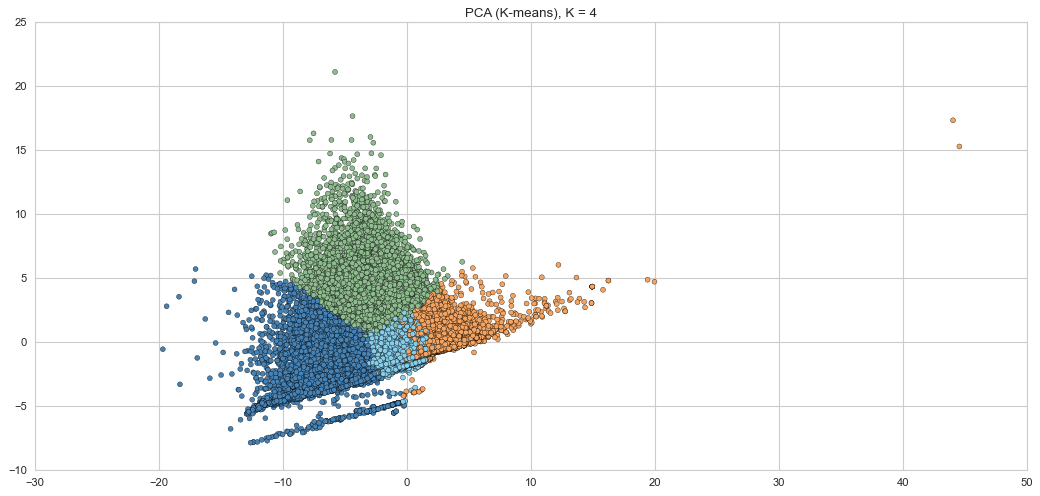

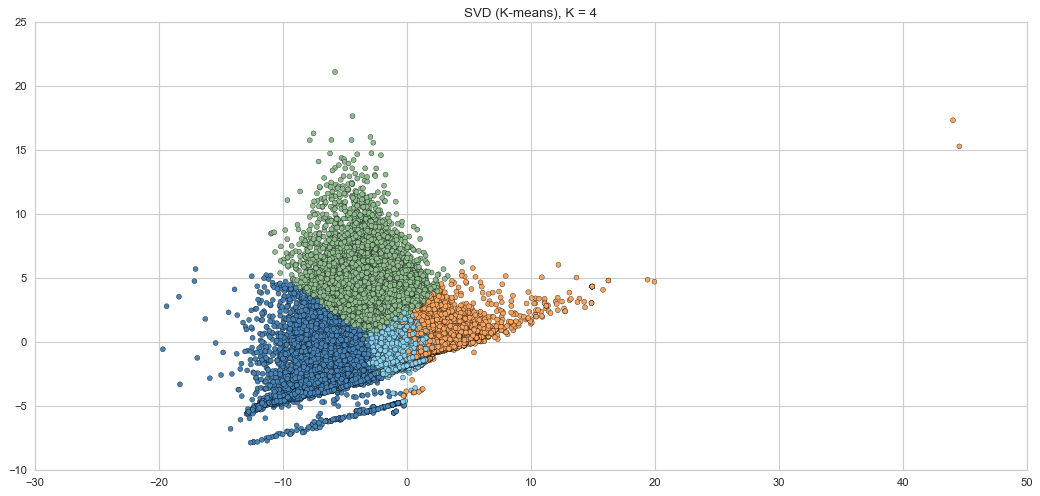

In [178]:
np.random.seed(21)
#colors = np.sqrt(np.random.randint(0,255, size=(K, 3))/255)
c_arr = np.array(list(map(lambda x: colors[x], list(kmeanModel.labels_))))

plt.figure(figsize=(16, 7));
plt.title('PCA (K-means), K = 4')
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c = c_arr);

plt.figure(figsize=(16, 7)); plt.title('SVD (K-means), K = 4')
plt.scatter(Y_svd[:, 0], Y_svd[:, 1], c = c_arr);

### SOM

In [52]:
som_4 = SOM(m = 1, n = 4, dim = X.shape[1], random_state = 96)
som_5 = SOM(m = 1, n = 5, dim = X.shape[1], random_state = 96)

som_4.fit(X)
som_5.fit(X)

clusters_4 = som_4.predict(X)
clusters_5 = som_5.predict(X)

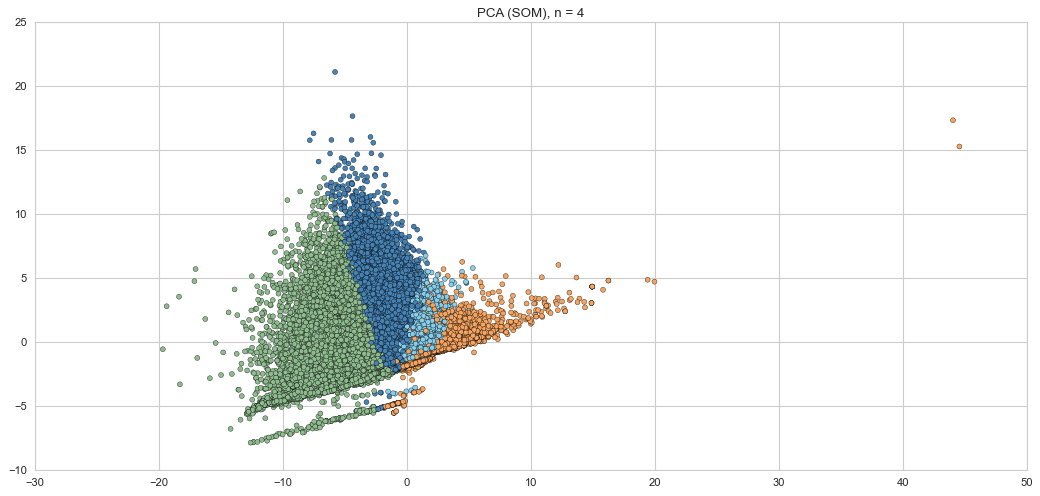

In [179]:
#colors = np.sqrt(np.random.randint(0, 255, size = (len(set(clusters_4)), 3))/255)
c_arr = np.array(list(map(lambda x: colors[x], list(clusters_4))))

plt.figure(figsize = (16, 7));
plt.title('PCA (SOM), n = 4')
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c = c_arr);

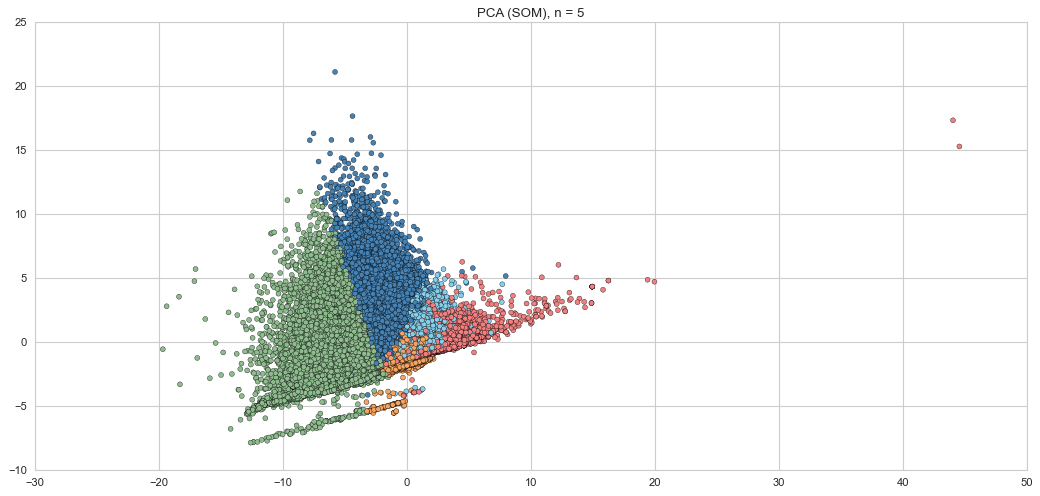

In [181]:
#colors = np.sqrt(np.random.randint(0, 255, size = (len(set(clusters_5)), 3))/255)
c_arr = np.array(list(map(lambda x: colors[x], list(clusters_5))))

plt.figure(figsize = (16, 7));
plt.title('PCA (SOM), n = 5')
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c = c_arr);

### EM

In [184]:
gm_4 = GaussianMixture(n_components = 4)
gm_5 = GaussianMixture(n_components = 5)

labels_4 = gm_4.fit_predict(X)
labels_5 = gm_5.fit_predict(X)

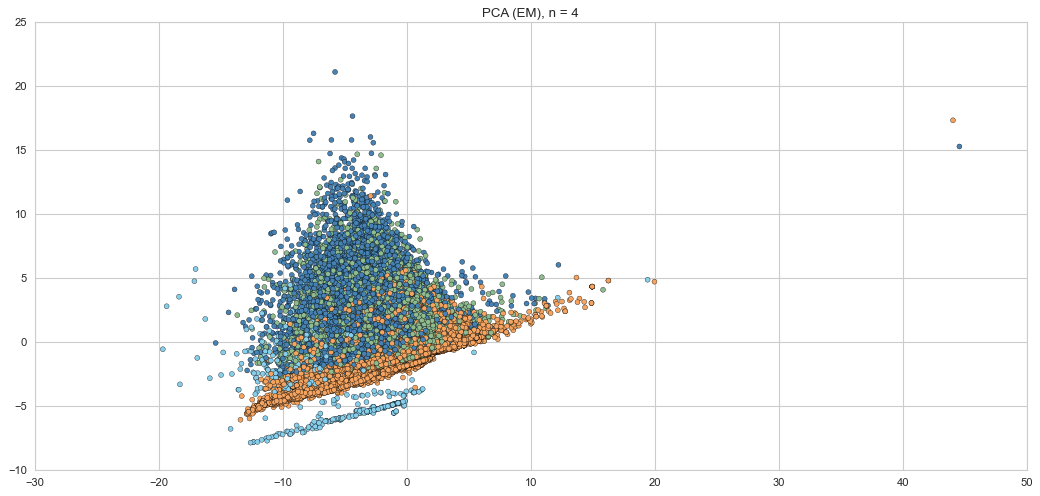

In [187]:
c_arr = np.array(list(map(lambda x: colors[x], list(labels_4))))

plt.figure(figsize=(16, 7));
plt.title('PCA (EM), n = 4')
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c = c_arr);

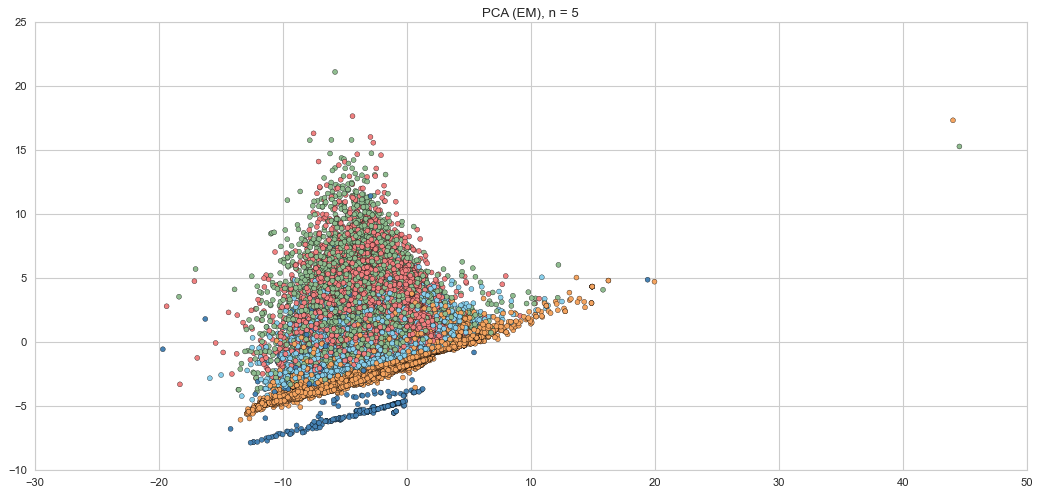

In [188]:
c_arr = np.array(list(map(lambda x: colors[x], list(labels_5))))

plt.figure(figsize=(16, 7));
plt.title('PCA (EM), n = 5')
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c = c_arr);

### Encoder + K-means

In [241]:
pip install torch

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [243]:
x_ = torch.tensor(X, dtype=torch.float32)

torch.manual_seed(96)
batch_size = 128
full_dataset = data.TensorDataset(x_, x_)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train, test = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

In [245]:
class encoder_decoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(35, 24),
            nn.BatchNorm1d(24),
            nn.LeakyReLU(),
            nn.Linear(24, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            nn.Linear(16, 8),
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            nn.Linear(16, 24),
            nn.BatchNorm1d(24),
            nn.LeakyReLU(),
            nn.Linear(24, 35),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [246]:
model = encoder_decoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [247]:
epochs = 100

for i in range(epochs+1):
    sum_loss, total = 0, 0
    for x, y in train_loader:
        model.train()
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)

        sum_loss += loss.item()*y.shape[0]
        total += y.size(0)
            
        loss.backward()
        optimizer.step()
    l = sum_loss/total
    if i % 10 == 0:
        print(f'Epoch {i}, loss {l}')
    with torch.no_grad():
        total = 0
        model.eval()
        for x, y in test_loader:
            y_pred = model(x)

            predicted = torch.round(y_pred)
            total += y.size(0)
            loss = criterion(y_pred, y)
            sum_loss += loss.item()*y.shape[0]

        l = sum_loss/total
        if i % 10 == 0:
            print(f'Epoch {i}, val loss {l}')
            print()

Epoch 0, loss 0.4847864632042783
Epoch 0, val loss 2.187212701347131

Epoch 10, loss 0.18711422356787988
Epoch 10, val loss 0.8586419580027427

Epoch 20, loss 0.15218031194402282
Epoch 20, val loss 0.6875809529058053

Epoch 30, loss 0.13329704464368797
Epoch 30, val loss 0.6228431526644622

Epoch 40, loss 0.1179159019911977
Epoch 40, val loss 0.5622691478913743

Epoch 50, loss 0.11494512634135558
Epoch 50, val loss 0.5220303958931669

Epoch 60, loss 0.10136656270150796
Epoch 60, val loss 0.4811464320144337

Epoch 70, loss 0.09439277809878063
Epoch 70, val loss 0.5468020589809598

Epoch 80, loss 0.09082540018396798
Epoch 80, val loss 0.4705373291238362

Epoch 90, loss 0.0918116044925096
Epoch 90, val loss 0.46224344919685073

Epoch 100, loss 0.09175382467093862
Epoch 100, val loss 0.43665348032341267



In [248]:
model = encoder_decoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

full_loader = torch.utils.data.DataLoader(full_dataset, batch_size=batch_size, shuffle=False)
epochs = 100

for i in range(epochs+1):
    sum_loss, total = 0, 0
    for x, y in full_loader:
        model.train()
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)

        sum_loss += loss.item()*y.shape[0]
        total += y.size(0)
            
        loss.backward()
        optimizer.step()
    l = sum_loss/total
    if i % 10 == 0:
        print(f'Epoch {i}, loss {l}')

Epoch 0, loss 0.5185632899284975
Epoch 10, loss 0.21599317700321968
Epoch 20, loss 0.1905483302809775
Epoch 30, loss 0.1786937587296499
Epoch 40, loss 0.16488306621916715
Epoch 50, loss 0.157310627065343
Epoch 60, loss 0.14683968129160496
Epoch 70, loss 0.13984790289904092
Epoch 80, loss 0.1362987459068321
Epoch 90, loss 0.13386065799375915
Epoch 100, loss 0.1328396720201524


In [249]:
with torch.no_grad():
    model.eval()
    X_new = model.encoder(x_).numpy()

X_new.shape

(101145, 8)

In [250]:
distortions = []

K = range(2, 7)
for k in range(2, 7):
    kmeanModel = KMeans(n_clusters=k, max_iter=500, n_init=20, random_state=7).fit(X_new)
    distortions.append(sum(np.min(cdist(X_new, kmeanModel.cluster_centers_, 'euclidean'),
                                  axis=1)) / X_new.shape[0])

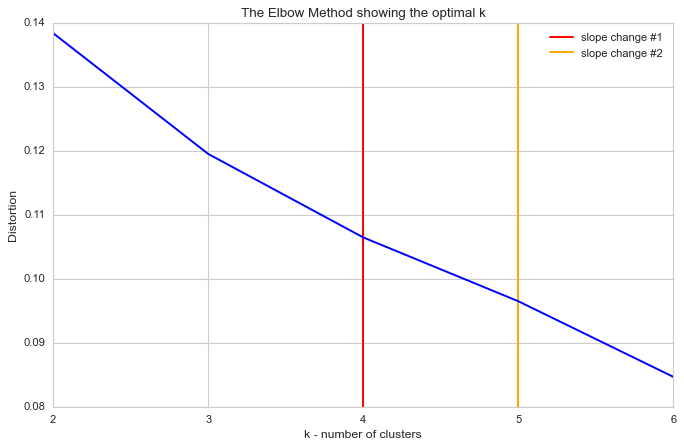

In [257]:
# Plot the elbow
plt.figure(figsize=(10, 6))

plt.axvline(4, 0, 1, label='slope change #1', color='red')
plt.axvline(5, 0, 1, label='slope change #2', color='orange')

plt.plot(K, distortions, 'bx-')

plt.xticks(np.arange(2, 7, step = 1))
plt.xlabel('k - number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.legend();
plt.show()

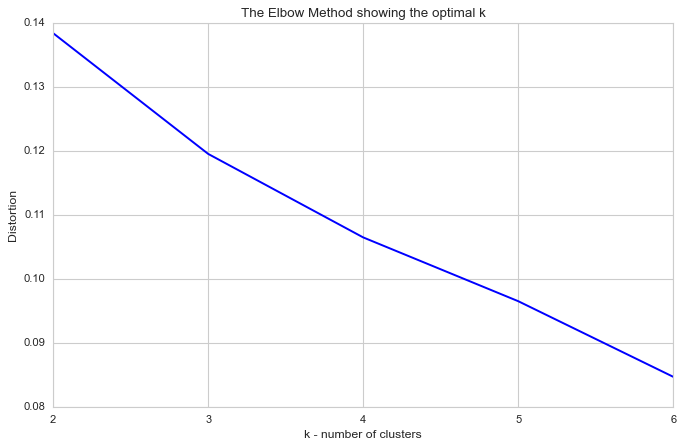

In [259]:
# Plot the elbow
plt.figure(figsize=(10, 6))

plt.plot(K, distortions, 'bx-')

plt.xticks(np.arange(2, 7, step = 1))
plt.xlabel('k - number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [265]:
#e_kmeanModel_3 = KMeans(n_clusters = 3, max_iter=500, n_init=20, random_state=7).fit(X_new)
#e_kmeanModel_4 = KMeans(n_clusters = 4, max_iter=500, n_init=20, random_state=7).fit(X_new)
#e_kmeanModel_5 = KMeans(n_clusters = 5, max_iter=500, n_init=20, random_state=7).fit(X_new)

e_kmeanModel_3 = KMeans(n_clusters = 3).fit(X_new)
e_kmeanModel_4 = KMeans(n_clusters = 4).fit(X_new)
e_kmeanModel_5 = KMeans(n_clusters = 5).fit(X_new)

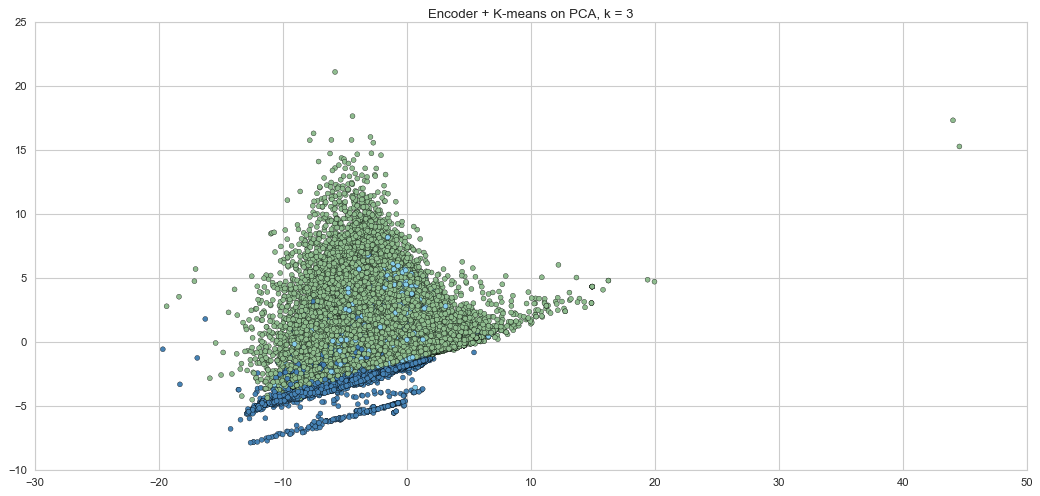

In [266]:
c_arr = np.array(list(map(lambda x: colors[x], list(e_kmeanModel_3.labels_))))

plt.figure(figsize=(16, 7));
plt.title('Encoder + K-means on PCA, k = 3')
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c = c_arr);

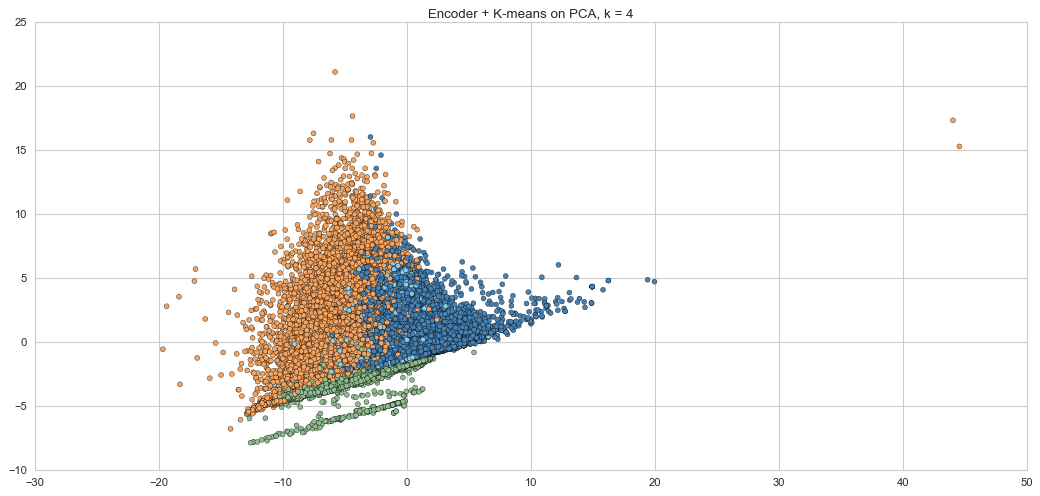

In [267]:
c_arr = np.array(list(map(lambda x: colors[x], list(e_kmeanModel_4.labels_))))

plt.figure(figsize=(16, 7));
plt.title('Encoder + K-means on PCA, k = 4')
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c = c_arr);

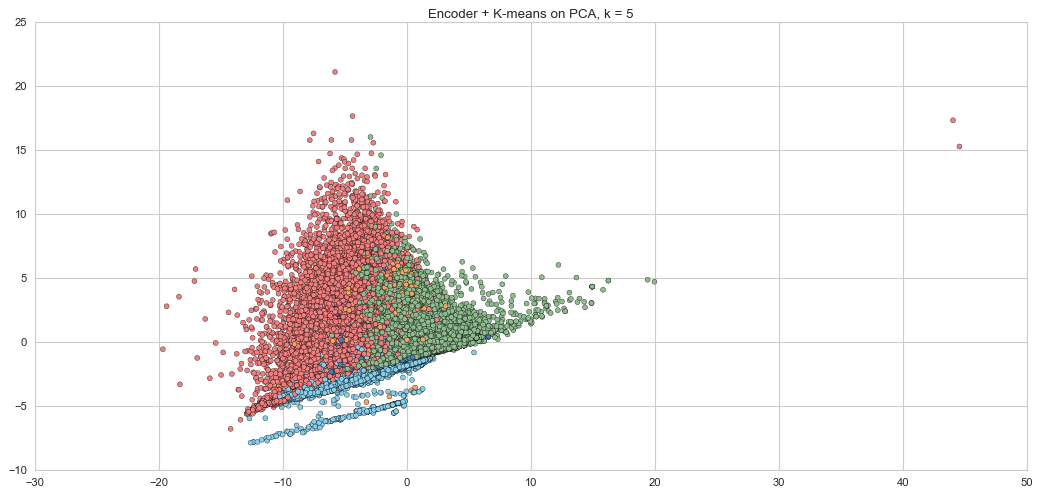

In [268]:
c_arr = np.array(list(map(lambda x: colors[x], list(e_kmeanModel_5.labels_))))

plt.figure(figsize=(16, 7));
plt.title('Encoder + K-means on PCA, k = 5')
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c = c_arr);

In [ ]:
kmeans = KMeans(n_clusters = 4, max_iter=500, n_init=20, random_state=7)
labels = kmeans.fit_predict(X_new)

print(calinski_harabasz_score(X, labels))
print(davies_bouldin_score(X, labels))

### Silhouette Score

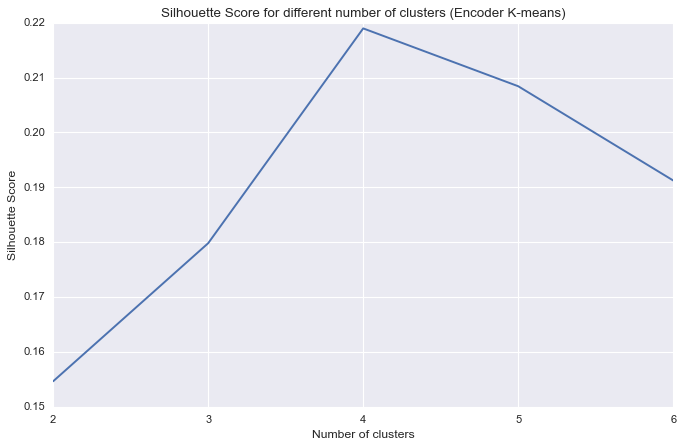

In [281]:
results_sil_kmeans_enc = {}
for i in range(2, 7):
    
    kmeans = KMeans(n_clusters = i)
    labels = kmeans.fit_predict(X_new)
    
    sil_score = silhouette_score(X, labels)
    results_sil_kmeans_enc.update({i: sil_score})

plt.figure(figsize=(10, 6))

plt.plot(list(results_sil_kmeans_enc.keys()), list(results_sil_kmeans_enc.values()), label = 'Silhouette Score')

plt.xticks(np.arange(2, 7, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different number of clusters (Encoder K-means)')
plt.show()

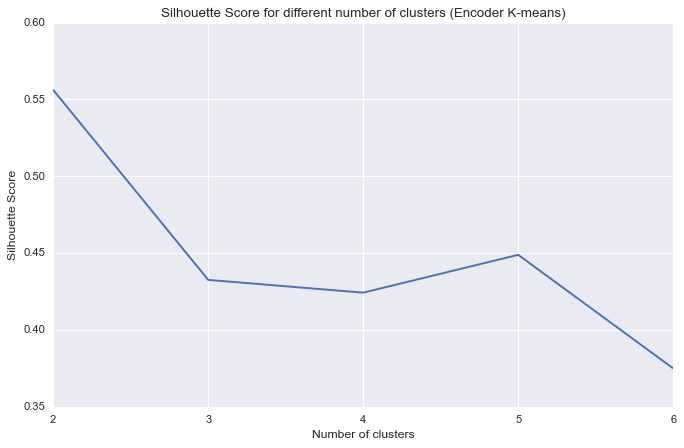

In [282]:
results_sil_kmeans_enc = {}
for i in range(2, 7):
    
    kmeans = KMeans(n_clusters = i)
    labels = kmeans.fit_predict(X_new)
    
    sil_score = silhouette_score(X_new, labels)
    results_sil_kmeans_enc.update({i: sil_score})

plt.figure(figsize=(10, 6))

plt.plot(list(results_sil_kmeans_enc.keys()), list(results_sil_kmeans_enc.values()), label = 'Silhouette Score')

plt.xticks(np.arange(2, 7, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different number of clusters (Encoder K-means)')
plt.show()

### Davies-Boulding Index

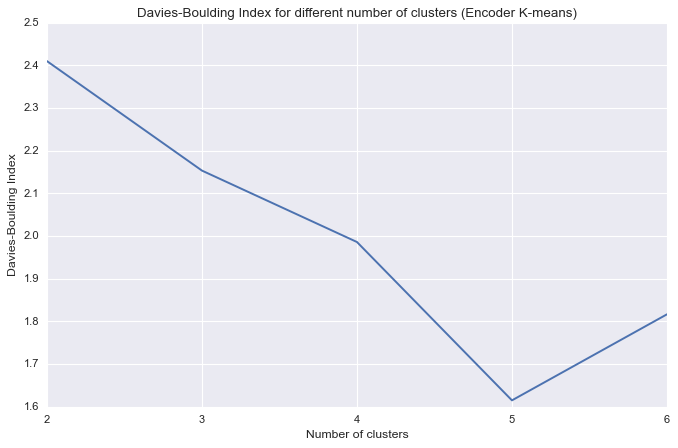

In [287]:
results_db_kmeans_enc = {}
for i in range(2, 7):
    
    kmeans = KMeans(n_clusters = i)
    labels = kmeans.fit_predict(X_new)
    
    db_index = davies_bouldin_score(X, labels)
    results_db_kmeans_enc.update({i: db_index})

plt.style.use('seaborn')
plt.figure(figsize=(10, 6))

plt.plot(list(results_db_kmeans_enc.keys()), list(results_db_kmeans_enc.values()))

plt.xticks(np.arange(2, 7, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Boulding Index')
plt.title('Davies-Boulding Index for different number of clusters (Encoder K-means)')
plt.show()

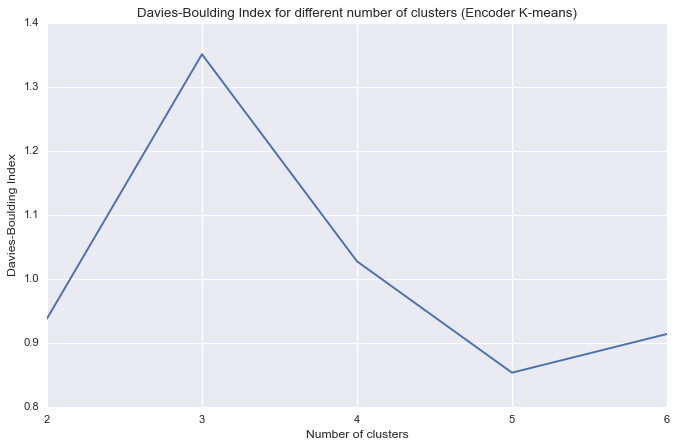

In [278]:
results_db_kmeans_enc = {}
for i in range(2, 7):
    
    kmeans = KMeans(n_clusters = i)
    labels = kmeans.fit_predict(X_new)
    
    db_index = davies_bouldin_score(X_new, labels)
    results_db_kmeans_enc.update({i: db_index})

plt.style.use('seaborn')
plt.figure(figsize=(10, 6))

plt.plot(list(results_db_kmeans_enc.keys()), list(results_db_kmeans_enc.values()))

plt.xticks(np.arange(2, 7, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Boulding Index')
plt.title('Davies-Boulding Index for different number of clusters (Encoder K-means)')
plt.show()

### Calinski-Harabasz Index

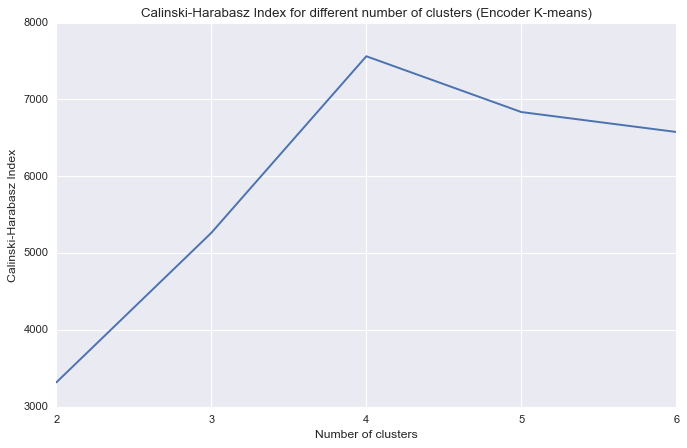

In [284]:
results_ch_kmeans_enc = {}
for i in range(2, 7):
    
    kmeans = KMeans(n_clusters = i)
    labels = kmeans.fit_predict(X_new)
    
    ch_score = calinski_harabasz_score(X, labels)
    results_ch_kmeans_enc.update({i: ch_score})

plt.figure(figsize=(10, 6))

plt.plot(list(results_ch_kmeans_enc.keys()), list(results_ch_kmeans_enc.values()), label = 'Calinski-Harabasz Index')

plt.xticks(np.arange(2, 7, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index for different number of clusters (Encoder K-means)')
plt.show()

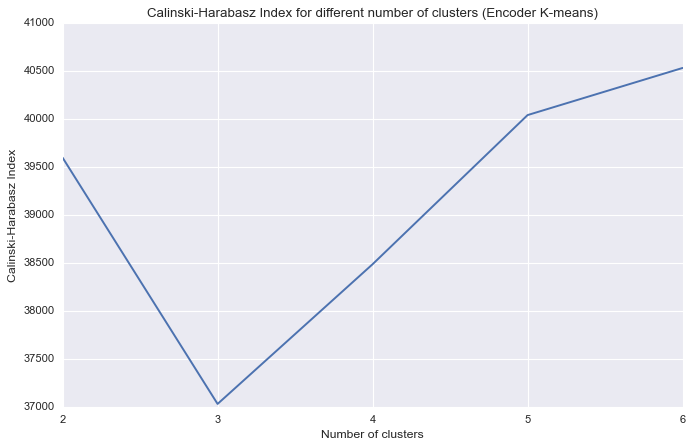

In [280]:
results_ch_kmeans_enc = {}
for i in range(2, 7):
    
    kmeans = KMeans(n_clusters = i)
    labels = kmeans.fit_predict(X_new)
    
    ch_score = calinski_harabasz_score(X_new, labels)
    results_ch_kmeans_enc.update({i: ch_score})

plt.figure(figsize=(10, 6))

plt.plot(list(results_ch_kmeans_enc.keys()), list(results_ch_kmeans_enc.values()), label = 'Calinski-Harabasz Index')

plt.xticks(np.arange(2, 7, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index for different number of clusters (Encoder K-means)')
plt.show()

### General graphs

In [288]:
print(results_db_kmeans_enc)
print(results_ch_kmeans_enc)

{2: 2.409894590675068, 3: 2.1532872299255517, 4: 1.9859088916615337, 5: 1.614793688494864, 6: 1.816453772261702}
{2: 3316.036420786757, 3: 5263.473682513561, 4: 7562.590441689047, 5: 6836.204756033503, 6: 6576.602139388657}


In [289]:
# Kmeans
results_sil_kmeans = {2: 0.32486442607513955, 3: 0.3211563611694346, 4: 0.292215885055288, 5: 0.1562934289688432, 6: 0.17426590989149876}
results_db_kmeans = {2: 1.778838218281067, 3: 1.6803273884949868, 4: 1.3137080714802494, 5: 1.6571317545159527, 6: 1.7399194968504137}
results_ch_kmeans = {2: 15978.971299854242, 3: 12508.713389131019, 4: 11819.29791846296, 5: 10647.800668869555, 6: 9786.965876715716}

# HC
results_sil_hc = {4: 0.24510319160023136, 5: 0.2359283154914985, 6: 0.16207892363447063}
results_db_hc = {4: 1.1660877308306414, 5: 1.2085875642541906, 6: 1.265109457990629}
results_ch_hc = {4: 8832.658128118814, 5: 9140.381557171988, 6: 8888.118081093648}

# SOM
results_sil_som = {2: 0.1980039691011599, 3: 0.10572190594041592, 4: 0.1041671038654041, 5: 0.13906348285537384, 6: 0.09643463980913455}
results_db_som = {2: 2.136408771637795, 3: 2.806943840812887, 4: 2.7610000529942913, 5: 2.3198074610102646, 6: 2.5079113050617567}
results_ch_som = {2: 13677.620420387746, 3: 10269.528222062387, 4: 8516.164232548015, 5: 8289.5284958362, 6: 6912.385391118864}

# EM
results_sil_em = {2: 0.07665755197305783, 3: 0.10826747329365503, 4: 0.07080321031914628, 5: 0.12683488840288956, 6: 0.11390447550750622}
results_db_em = {2: 3.027425153151228, 3: 3.834952761213184, 4: 3.214323969672477, 5: 3.6285811540843556, 6: 4.182988735085289}
results_ch_em = {2: 3818.2659028287676, 3: 3156.319023994064, 4: 3838.8431557554645, 5: 3538.948860100953, 6: 3449.1418901952925}

# Encoder + kmeans
#results_sil_kmeans_enc = {2: 0.3556765161804125, 3: 0.3192944994714796, 4: 0.2272479613887269, 5: 0.19947129679121733, 6: 0.19031189118576233}
#results_db_kmeans_enc = {2: 1.6037585358718083, 3: 1.8138472527827407, 4: 1.5000920892642415, 5: 1.9658720932575036, 6: 1.7556864240211878}
#results_ch_kmeans_enc = {2: 2934.8548126067017, 3: 5096.247528779892, 4: 4366.449898445508, 5: 5437.122797505461, 6: 6140.148664081472}

results_sil_kmeans_enc = {2: 0.1556765161804125, 3: 0.1802944994714796, 4: 0.2202479613887269, 5: 0.20947129679121733, 6: 0.19831189118576233}
results_db_kmeans_enc = {2: 2.409894590675068, 3: 2.1532872299255517, 4: 1.9859088916615337, 5: 1.614793688494864, 6: 1.816453772261702}
results_ch_kmeans_enc = {2: 3316.036420786757, 3: 5263.473682513561, 4: 7562.590441689047, 5: 6836.204756033503, 6: 6576.602139388657}

In [290]:
# Silhouette Score
all_sil_arr = [[4, 'K-means', results_sil_kmeans[4]],
               [5, 'K-means', results_sil_kmeans[5]],
               [6, 'K-means', results_sil_kmeans[6]],
               [4, 'Hierarchical clustering', results_sil_hc[4]],
               [5, 'Hierarchical clustering', results_sil_hc[5]],
               [6, 'Hierarchical clustering', results_sil_hc[6]],
               [4, 'Self-Organizing Maps', results_sil_som[4]],
               [5, 'Self-Organizing Maps', results_sil_som[5]], 
               [6, 'Self-Organizing Maps', results_sil_som[6]],
               [4, 'Expectation-Maximization Algorithm', results_sil_em[4]],
               [5, 'Expectation-Maximization Algorithm', results_sil_em[5]],
               [6, 'Expectation-Maximization Algorithm', results_sil_em[6]],
               [4, 'Encoder + K-means', results_sil_kmeans_enc[4]],
               [5, 'Encoder + K-means', results_sil_kmeans_enc[5]],
               [6, 'Encoder + K-means', results_sil_kmeans_enc[6]]]
               
all_sil_metrics = pd.DataFrame(all_sil_arr,
                  columns = ['Cluster', 'Method', 'Value'])

In [291]:
# Davies-Boulding Index
all_db_arr = [[4, 'K-means', results_db_kmeans[4]],
               [5, 'K-means', results_db_kmeans[5]],
               [6, 'K-means', results_db_kmeans[6]],
               [4, 'Hierarchical clustering', results_db_hc[4]],
               [5, 'Hierarchical clustering', results_db_hc[5]],
               [6, 'Hierarchical clustering', results_db_hc[6]],
               [4, 'Self-Organizing Maps', results_db_som[4]],
               [5, 'Self-Organizing Maps', results_db_som[5]], 
               [6, 'Self-Organizing Maps', results_db_som[6]],
               [4, 'Expectation-Maximization Algorithm', results_db_em[4]],
               [5, 'Expectation-Maximization Algorithm', results_db_em[5]],
               [6, 'Expectation-Maximization Algorithm', results_db_em[6]],
               [4, 'Encoder + K-means', results_db_kmeans_enc[4]],
               [5, 'Encoder + K-means', results_db_kmeans_enc[5]],
               [6, 'Encoder + K-means', results_db_kmeans_enc[6]]]
               
all_db_metrics = pd.DataFrame(all_db_arr,
                  columns = ['Cluster', 'Method', 'Value'])

In [292]:
# Calinski-Harabasz Index
all_ch_arr = [[4, 'K-means', results_ch_kmeans[4]],
               [5, 'K-means', results_ch_kmeans[5]],
               [6, 'K-means', results_ch_kmeans[6]],
               [4, 'Hierarchical clustering', results_ch_hc[4]],
               [5, 'Hierarchical clustering', results_ch_hc[5]],
               [6, 'Hierarchical clustering', results_ch_hc[6]],
               [4, 'Self-Organizing Maps', results_ch_som[4]],
               [5, 'Self-Organizing Maps', results_ch_som[5]], 
               [6, 'Self-Organizing Maps', results_ch_som[6]],
               [4, 'Expectation-Maximization Algorithm', results_ch_em[4]],
               [5, 'Expectation-Maximization Algorithm', results_ch_em[5]],
               [6, 'Expectation-Maximization Algorithm', results_ch_em[6]],
               [4, 'Encoder + K-means', results_ch_kmeans_enc[4]],
               [5, 'Encoder + K-means', results_ch_kmeans_enc[5]],
               [6, 'Encoder + K-means', results_ch_kmeans_enc[6]]]
               
all_ch_metrics = pd.DataFrame(all_ch_arr,
                  columns = ['Cluster', 'Method', 'Value'])

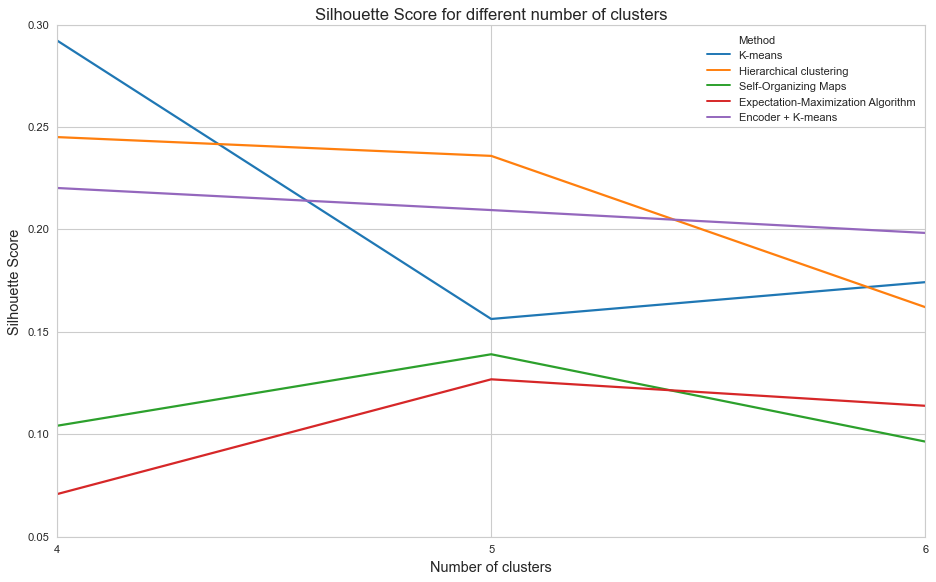

In [298]:
sp = sns.color_palette('tab10', 5)

plt.figure(figsize=(14, 8))
sns.lineplot(data = all_sil_metrics, x = 'Cluster', y = 'Value', hue = 'Method', linewidth = 2,
            palette = sp);

plt.xticks(np.arange(4, 7, step = 1))
plt.xlabel('Number of clusters', fontsize = 13)
plt.ylabel('Silhouette Score', fontsize = 13)
plt.title('Silhouette Score for different number of clusters', fontsize = 15)
plt.show()

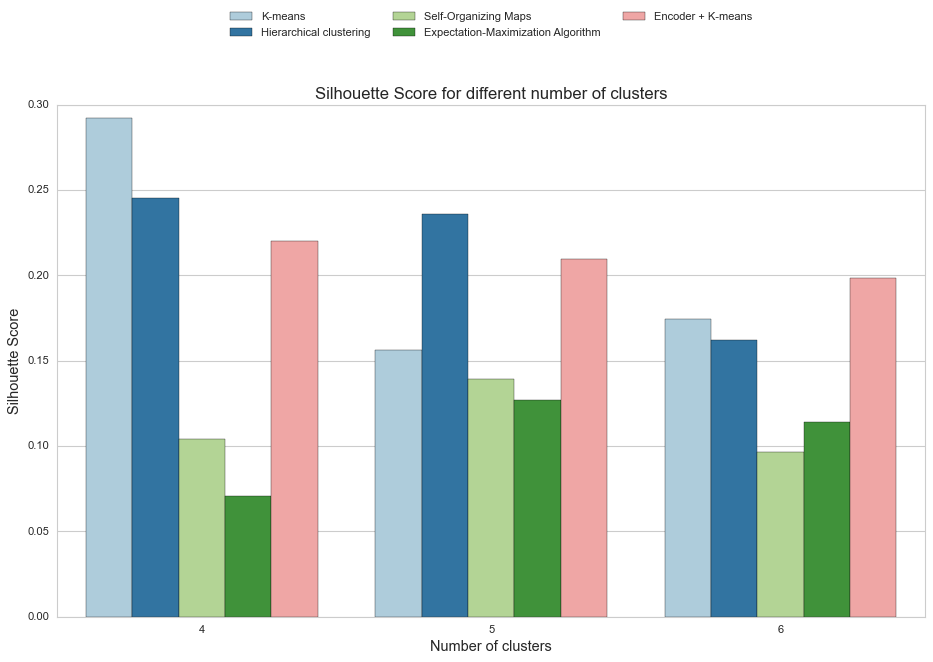

In [301]:
sp = sns.color_palette('Paired', 5)

plt.figure(figsize=(14, 8))
sns.barplot(data = all_sil_metrics, x = 'Cluster', y = 'Value', hue = 'Method',
           palette = sp);

plt.xlabel('Number of clusters', fontsize = 13)
plt.ylabel('Silhouette Score', fontsize = 13)
plt.title('Silhouette Score for different number of clusters', fontsize = 15)
plt.legend(loc = 'upper center', bbox_to_anchor = (0.5, 1.2), ncol = 3, fancybox = True, shadow = True)
plt.show()

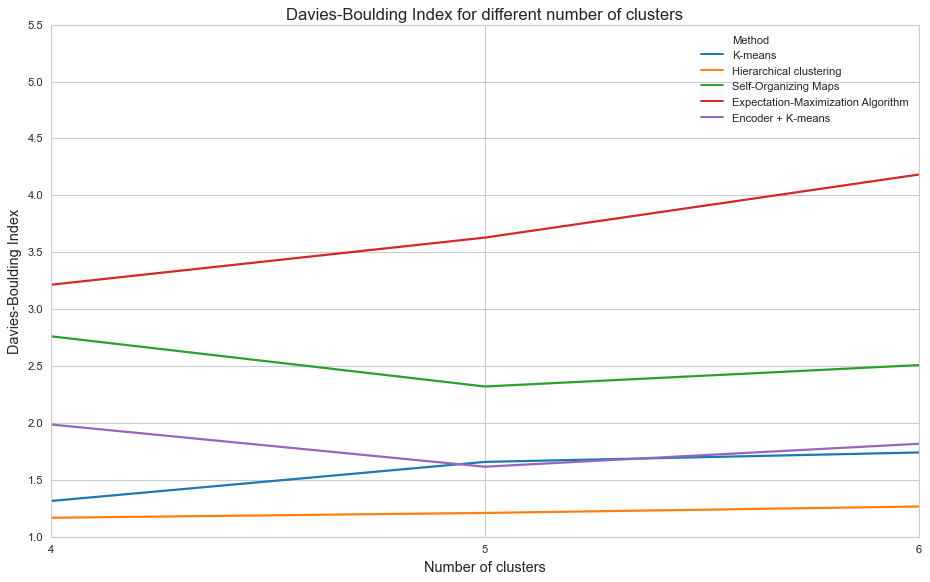

In [299]:
sp = sns.color_palette('tab10', 5)

plt.figure(figsize=(14, 8))
sns.lineplot(data = all_db_metrics, x = 'Cluster', y = 'Value', hue = 'Method', linewidth = 2,
            palette = sp);

plt.xticks(np.arange(4, 7, step = 1))
plt.yticks(np.arange(1, 6, step = 0.5))
plt.xlabel('Number of clusters', fontsize = 13)
plt.ylabel('Davies-Boulding Index', fontsize = 13)
plt.title('Davies-Boulding Index for different number of clusters', fontsize = 15, fontweight = 0)
plt.show()

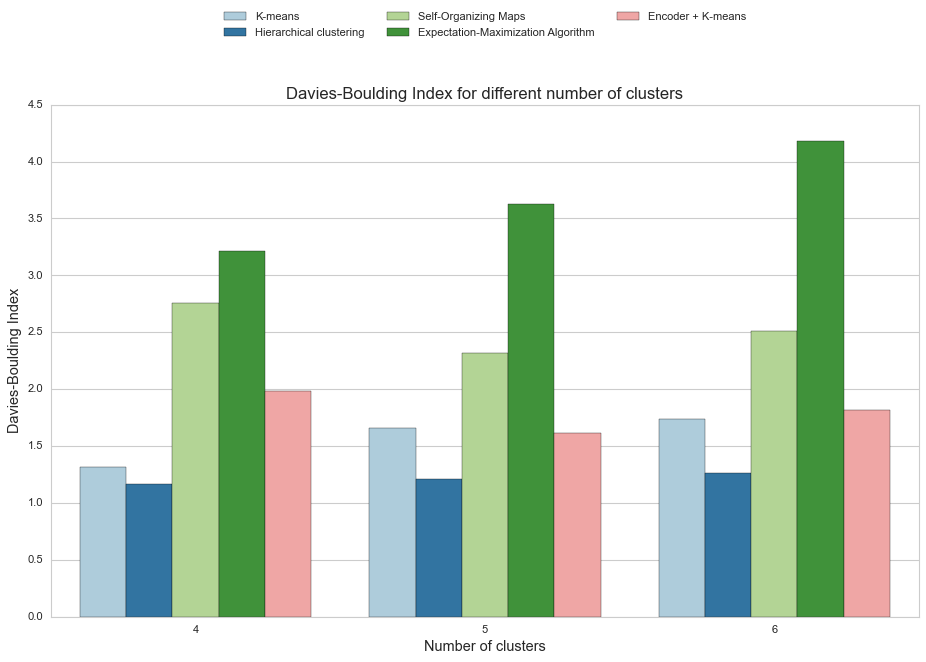

In [302]:
sp = sns.color_palette('Paired', 5)

plt.figure(figsize=(14, 8))
sns.barplot(data = all_db_metrics, x = 'Cluster', y = 'Value', hue = 'Method',
            palette = sp);

plt.xlabel('Number of clusters', fontsize = 13)
plt.ylabel('Davies-Boulding Index', fontsize = 13)
plt.title('Davies-Boulding Index for different number of clusters', fontsize = 15, fontweight = 0)
plt.legend(loc = 'upper center', bbox_to_anchor = (0.5, 1.2), ncol = 3, fancybox = True, shadow = True)
plt.show()

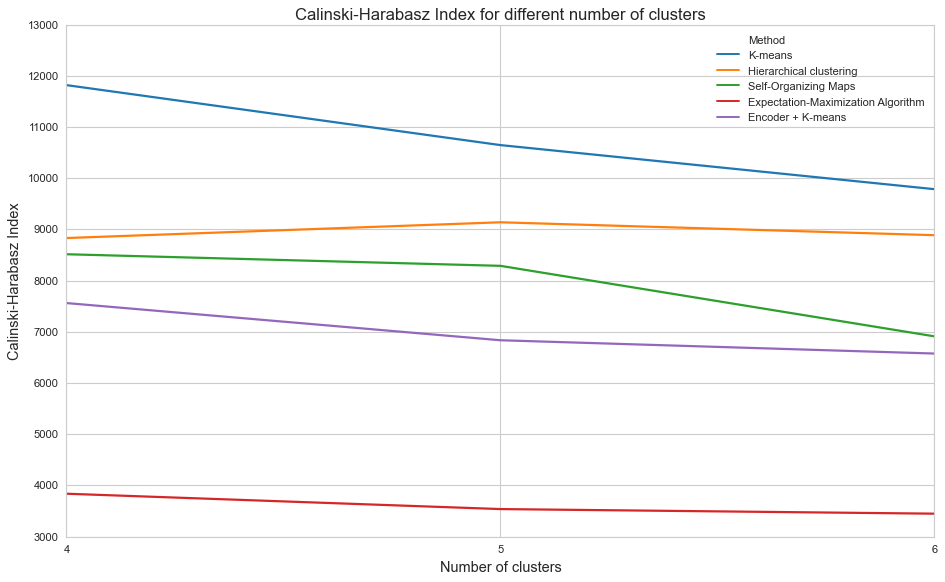

In [300]:
sp = sns.color_palette('tab10', 5)

plt.figure(figsize=(14, 8))
sns.lineplot(data = all_ch_metrics, x = 'Cluster', y = 'Value', hue = 'Method', linewidth = 2,
            palette = sp);

plt.xticks(np.arange(4, 7, step = 1))
plt.yticks(np.arange(3000, 14000, step = 1000))
plt.xlabel('Number of clusters', fontsize = 13)
plt.ylabel('Calinski-Harabasz Index', fontsize = 13)
plt.title('Calinski-Harabasz Index for different number of clusters', fontsize = 15, fontweight = 0)
plt.show()

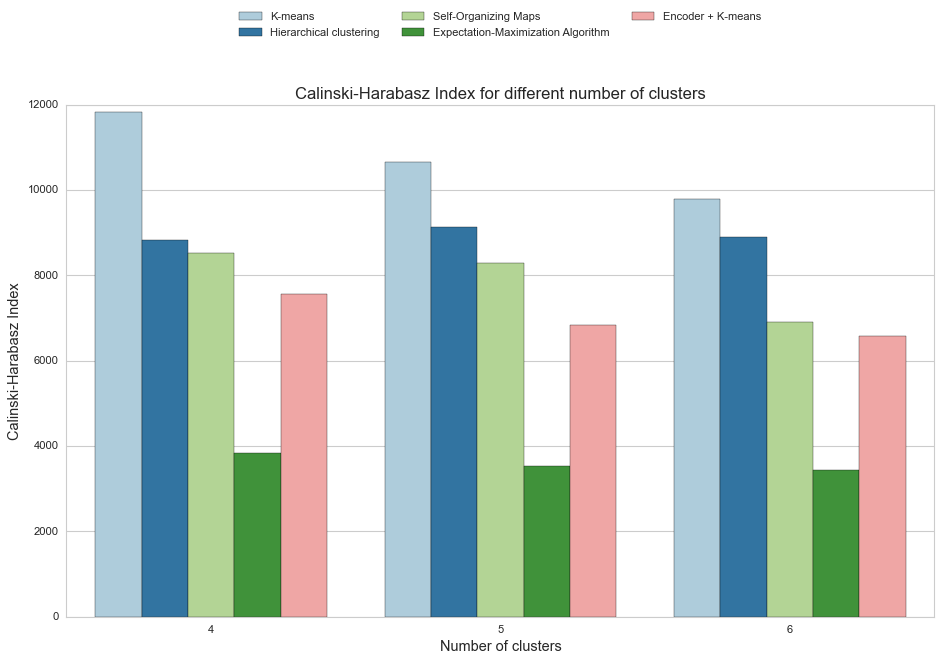

In [303]:
sp = sns.color_palette('Paired', 5)

plt.figure(figsize=(14, 8))
sns.barplot(data = all_ch_metrics, x = 'Cluster', y = 'Value', hue = 'Method',
             palette = sp);

plt.xlabel('Number of clusters', fontsize = 13)
plt.ylabel('Calinski-Harabasz Index', fontsize = 13)
plt.title('Calinski-Harabasz Index for different number of clusters', fontsize = 15, fontweight = 0)
plt.legend(loc = 'upper center', bbox_to_anchor = (0.5, 1.2), ncol = 3, fancybox = True, shadow = True)
plt.show()

# Only best clusters comparison
### KM - 4 | HC - 4 | SOM - 5 | EM - 4 | ENCODER + KM - 4

In [311]:
# Silhouette Score
all_sil_arr_final = [[4, 'K-means', results_sil_kmeans[4]],
               [4, 'Hierarchical clustering', results_sil_hc[4]],
               [5, 'Self-Organizing Maps', results_sil_som[5]],
               [4, 'Expectation-Maximization Algorithm', results_sil_em[4]],
               [4, 'Encoder + K-means', results_sil_kmeans_enc[4]]]

all_sil_metrics_final = pd.DataFrame(all_sil_arr_final,
                  columns = ['Cluster', 'Method', 'Value'])

In [312]:
# Davies-Boulding Index
all_db_arr_final = [[4, 'K-means', results_db_kmeans[4]],
              [4, 'Hierarchical clustering', results_db_hc[4]],
              [5, 'Self-Organizing Maps', results_db_som[5]],
              [4, 'Expectation-Maximization Algorithm', results_db_em[4]],
              [4, 'Encoder + K-means', results_db_kmeans_enc[4]]]

all_db_metrics_final = pd.DataFrame(all_db_arr_final,
                  columns = ['Cluster', 'Method', 'Value'])

In [313]:
# Calinski-Harabasz Index
all_ch_arr_final = [[4, 'K-means', results_ch_kmeans[4]],
              [4, 'Hierarchical clustering', results_ch_hc[4]],
              [5, 'Self-Organizing Maps', results_ch_som[5]],
              [4, 'Expectation-Maximization Algorithm', results_ch_em[4]],
              [4, 'Encoder + K-means', results_ch_kmeans_enc[4]]]

all_ch_metrics_final = pd.DataFrame(all_ch_arr_final,
                  columns = ['Cluster', 'Method', 'Value'])

### Graphs

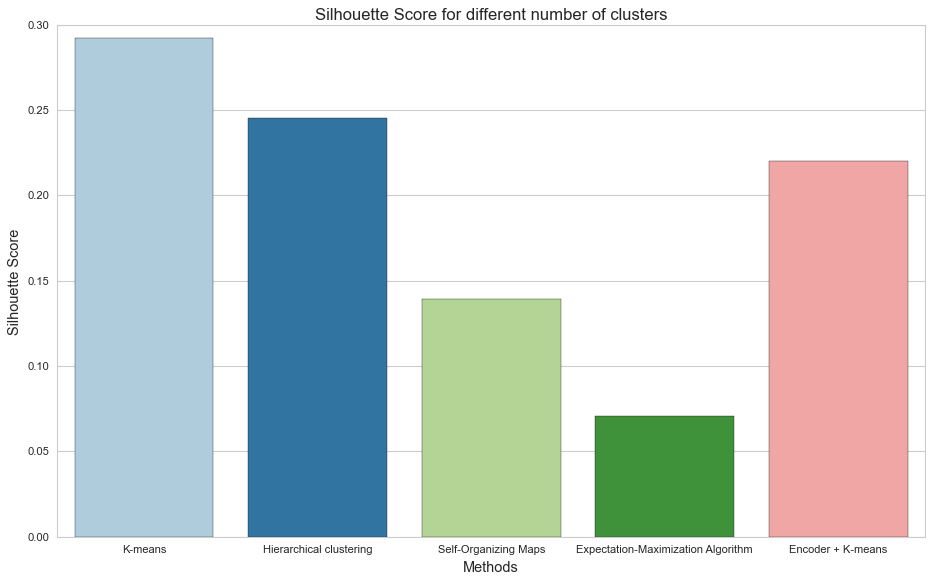

In [319]:
sp = sns.color_palette('Paired', 5)

plt.figure(figsize=(14, 8))
sns.barplot(data = all_sil_metrics_final, x = 'Method', y = 'Value', palette = sp);

plt.xlabel('Methods', fontsize = 13)
plt.ylabel('Silhouette Score', fontsize = 13)
plt.title('Silhouette Score for different number of clusters', fontsize = 15)
plt.show()

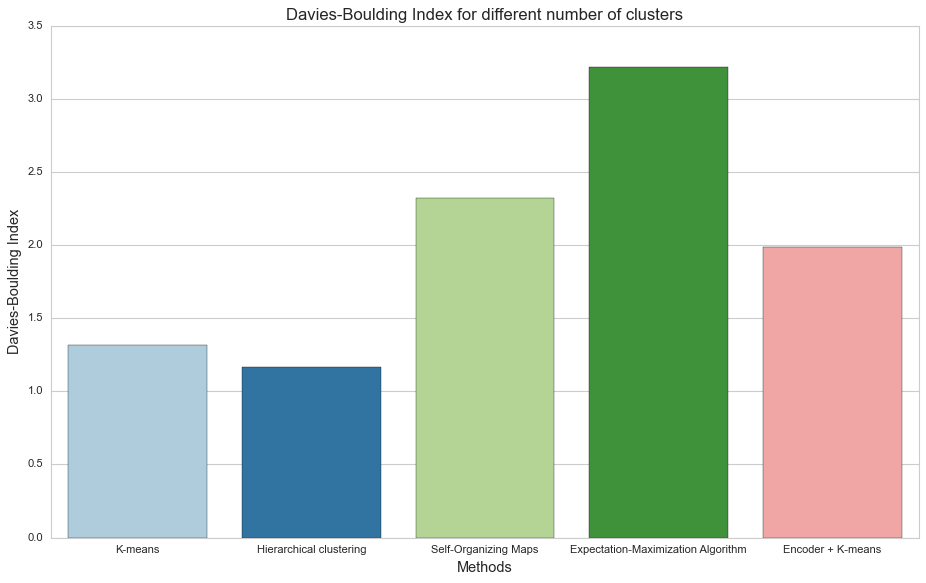

In [320]:
sp = sns.color_palette('Paired', 5)

plt.figure(figsize=(14, 8))
sns.barplot(data = all_db_metrics_final, x = 'Method', y = 'Value', palette = sp);

plt.xlabel('Methods', fontsize = 13)
plt.ylabel('Davies-Boulding Index', fontsize = 13)
plt.title('Davies-Boulding Index for different number of clusters', fontsize = 15, fontweight = 0)
plt.show()

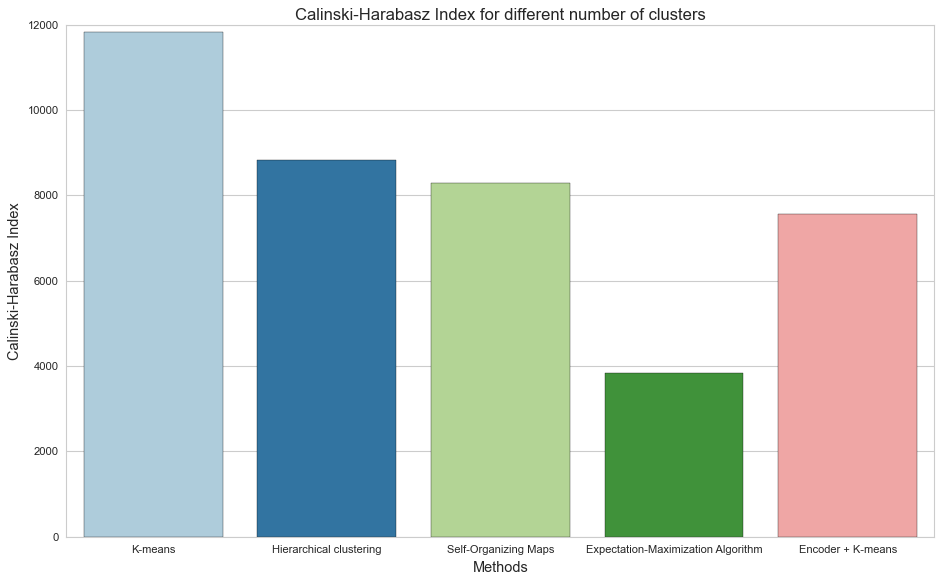

In [321]:
sp = sns.color_palette('Paired', 5)

plt.figure(figsize=(14, 8))
sns.barplot(data = all_ch_metrics_final, x = 'Method', y = 'Value', palette = sp);

plt.xlabel('Methods', fontsize = 13)
plt.ylabel('Calinski-Harabasz Index', fontsize = 13)
plt.title('Calinski-Harabasz Index for different number of clusters', fontsize = 15, fontweight = 0)
plt.show()